In [1]:
"""
ABHI Economies - Problem Set 4

Joe Emmens

Partial and General Equilibrium Models
"""

'\nABHI Economies - Problem Set 4\nJoe Emmens\nPartial and General Equilibrium Models\n'

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import quantecon as qe
from scipy import stats
from scipy import interpolate
from sympy.solvers import solve
from sympy import Symbol

In [3]:
path_name = ""
os.chdir(f"{path_name}")

In [4]:
def approx_markov(rho, sigma_u, m=3, n=4):

    F = stats.norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0]-rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P



In [5]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array"""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [6]:
@np.vectorize
def CRRA(y, a, a_prime, w, q, sigma):
    """ CRRA utility function"""

    c = w*y + a - q*a_prime
    if c > 0:

        if sigma > 1:
            u = ((c)**(1 - sigma) - 1) / (1 - sigma)

        elif sigma == 1:
            u = np.log(c)
    else:
        u = -1000000
    return u

@np.vectorize
def cons(y, a, a_prime, w, q):
    """ Consumption function"""

    return w*y + a - q*a_prime

@np.vectorize
def quadratic(y, a, a_prime, w, q, c_bar):
    """ Quadratic utility function"""
    c = w*y + a - q*a_prime
    if c > 0:
        u = -(1/2) * (c - c_bar)**2
    else:
        u = -1000000
    return u

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [19]:
def SolveModel(utility, Borrowing=True, Aiyagari=False, method="discrete", m=3, r=0.04, sigma=2, p=0, rho=0.06, w=1,
               N=2, CV=0, sigma_y=0, gamma=0, a_max=150, a_num=100, c_bar=100):
    """
    A general model capable of solving a range of ABHI model economies,
        Borrowing Capacities
            1) Natural Borrowing Limit
            2) Zero Borrowing Limit
        Value Function approximation methods
            1) Discrete
            2) B-Spline continuous methods
    Furthermore running Aiyagari = True increases the state space and introduces a Tauchen process,
    """

    N=N

    q = 1 / (1 + r)
    beta = 1 / (1 + rho)


    if Aiyagari == False:

        trans_mat = np.array([[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]])

        y_min = 1 - sigma_y
        y_max = 1 + sigma_y
        y_grid = np.linspace(y_min, y_max, N)

    if Aiyagari == True:

        y_grid, trans_mat = approx_markov(p, CV, m, N)
        y_min = y_grid[0]
        y_max = y_grid[N-1]



    if Borrowing == True:

        Abar = -1*((w / r) * -y_min)

    elif Borrowing == False:

        Abar = 0.001

    else:
        print("Borrowing must either be True or False")

    a_grid = np.linspace(Abar, a_max, a_num)

    M = np.zeros((N, a_num, a_num))

    for (idy, y) in enumerate(y_grid):
        for (ida, a) in enumerate(a_grid):
            for (ida_p, a_prime) in enumerate(a_grid):

                if utility == CRRA:

                    M[idy, ida, ida_p] = utility(y, a, a_prime, w=w, q=q, sigma=sigma)

                elif utility == quadratic:

                    M[idy, ida, ida_p] = utility(y, a, a_prime, w=w, q=q, c_bar=c_bar)

    X = np.ones(np.shape(M))
    if method == "discrete":

        V = np.zeros((N , a_num))

        for y in range(N):
            for a in range(a_num):

                V = np.dot(trans_mat, V)
                X[y][:, a] = M[y][:, a] + beta*V[y][a]

        V1 = X.max(2)
        a_policy = np.argmax(X, axis=2)
        OptimalPath = [V, V1]

        niters = 1
        ga = np.zeros((N, a_num))
        gc = np.zeros((N, a_num))
        while np.linalg.norm(V1 - V) > 10**-4 and niters<400:

            for y in range(N):
                for a in range(a_num):

                    V1 = np.dot(trans_mat, V1)

                    X[y][:, a] = M[y][:, a] + beta*V1[y][a]

            V1 = X.max(2)
            a_policy = np.argmax(X, axis=2)
            for y in range(N):
                for a in range(a_num):

                    ga[y, a] = a_grid[a_policy[y, a]]

            for (idy, y) in enumerate(y_grid):
                for (ida, a) in enumerate(a_grid):

                    gc[idy, ida] = w*y + a - q*ga[idy, ida]


            OptimalPath.append(V1)

            V1 = OptimalPath[-1]

            V = OptimalPath[-2]

            niters = niters + 1

        solution = [V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy]

    if method == "continuous":

        a_grid = np.linspace(Abar, a_max, a_num)
        yy, aa = np.meshgrid(y_grid, a_grid)
        V = np.zeros((N, a_num))

        spline = interpolate.bisplrep(yy, aa, (np.dot(trans_mat, V)), s=6, kx=4, ky=4)
        val = interpolate.bisplev(y_grid, a_grid, spline)


        M = np.ones((N, a_num, a_num))

        for (idy, y) in enumerate(y_grid):
            for (ida, a) in enumerate(a_grid):
                for (ida_p, a_prime) in enumerate(a_grid):

                    M[idy, ida, ida_p] = CRRA(y, a, a_prime, w=w, q=q, sigma=sigma)

        X = np.ones(np.shape(M))*-1000000

        for y in range(N):
            for a in range(a_num):

                X[y][:, a] = M[y][:, a] + beta*val[y, a]

        V1 = X.max(2)

        OptimalPath = [V, V1]

        niters = 1
        ga = np.zeros((N, a_num))
        gc = np.zeros((N, a_num))
        while np.linalg.norm(V1 - V) > 10**-4 and niters<400:

            for y in range(N):
                for a in range(a_num):

                    spline = interpolate.bisplrep(yy, aa, (np.dot(trans_mat, V1)), s=6, kx=4, ky=4)
                    val = interpolate.bisplev(y_grid, a_grid, spline)

                    X[y][:, a] = M[y][:, a] + beta*val[y, a]

            V1 = X.max(2)

            a_policy = np.argmax(X, axis=2)
            for y in range(N):
                for a in range(a_num):

                    ga[y, a] = a_grid[a_policy[y, a]]

            for (idy, y) in enumerate(y_grid):
                for (ida, a) in enumerate(a_grid):

                    gc[idy, ida] = w*y + a - q*ga[idy, ida]


            OptimalPath.append(V1)
            V1 = OptimalPath[-1]
            V = OptimalPath[-2]

            niters = niters + 1

    solution = V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy

    return solution

In [20]:
"""Plot value function convergence """
def SolPlots(V1, ga, gc, a_grid, specs="", fig_name="Missing"):

    """Plot value function and assets policy """

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, facecolor="w", figsize=(14,6))
    fig.suptitle(f"{specs}", fontsize=20, c="darkblue")
    p1 = ax1.plot(a_grid, V1[0], lw=2, c="darkslategray", label=r"$y = Y_{min}$")
    p2 = ax1.plot(a_grid, V1[1], lw=2, c="firebrick", label=r"$y = Y_{max}$")
    ax1.set_title("Value Function",c="darkblue", fontsize=14)
    ax1.set_xlabel("a", fontsize=14)

    ax2.plot(a_grid, ga[0], lw=2,c="darkslategray", label=r"$y = Y_{min}$")
    ax2.plot(a_grid, ga[1], lw=2,c="firebrick", label=r"$y = Y_{max}$")
    ax2.set_xlabel("a", fontsize=14)
    ax2.set_ylabel("a'", fontsize=14)
    ax2.set_title("Assets Policy Function",c="darkblue", fontsize=14)

    ax3.plot(a_grid, gc[0], lw=2,c="darkslategray", label=r"$y = Y_{min}$")
    ax3.plot(a_grid, gc[1], lw=2,c="firebrick", label=r"$y = Y_{max}$")
    ax3.set_xlabel("a", fontsize=14)
    ax3.set_ylabel("c", fontsize=14)
    ax3.set_title("Consumption Policy Function",c="darkblue", fontsize=14)

    ps = p1+p2
    labs = [p.get_label() for p in ps]
    ax1.legend(ps, labs, loc=0, fontsize="x-large")
    
    plt.tight_layout()
    
    fig.savefig(f"{fig_name}")


In [21]:
def ConsPath(a_grid, T=45, specs="", file_name="Missing", seed=np.random.seed(1)):

    seed

    y_shock = np.random.choice([0, 1], 1)

    a_0 = a_grid[0]
    ida = np.where(a_grid == a_0)[0]
    c_0 = gc[y_shock, ida]

    y_shocks = [y_shock]

    cons_path = [c_0]
    asset_path = [a_0]

    for t in range(1, T):

        y_shock = np.random.choice([0, 1], 1)
        ida = np.where(a_grid == asset_path[-1])[0]

        a_prime = ga[y_shock, ida]
        c = gc[y_shock, ida]

        y_shocks.append(y_shock)

        asset_path.append(a_prime)
        cons_path.append(c)

    time = np.arange(T)
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(time, cons_path, label = "Consumption Path", c="firebrick")
    ax.plot(time, asset_path, label = "Asset Path", c="darkslategray")

    ax2 = ax.twinx()
    ax2.scatter(time, y_shocks, label="y shocks", c="grey", alpha=0.5)
    ax2.axes.yaxis.set_ticks([])

    scatter_legend = mpatches.Patch(color='firebrick', label='Consumption')
    scatter_cons = mpatches.Patch(color='darkslategray', label='Asset')
    scatter_ass = mpatches.Patch(color='grey', label='y shocks')

    plt.legend(handles=[scatter_legend, scatter_cons, scatter_ass], loc=0)

    plt.title(f"{specs}", fontsize=14)
    plt.xlabel("Time")
    plt.tight_layout()

    fig.savefig(f"{file_name}")


    return np.array(cons_path), np.array(asset_path)




C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-21-4bcfd33995e2>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(cons_path), np.array(asset_path)


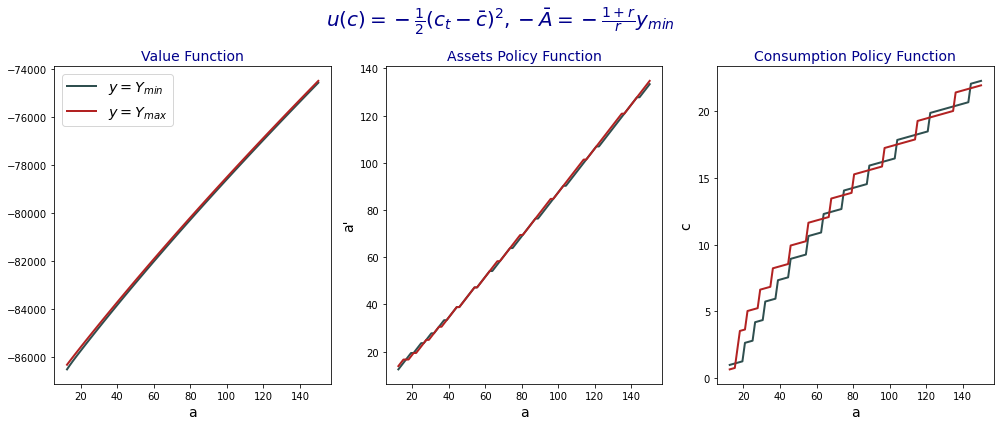

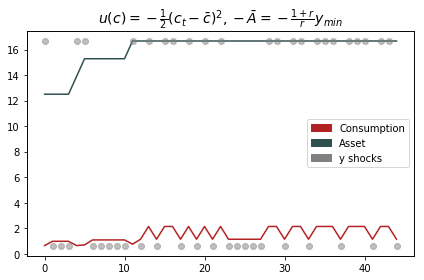

In [22]:
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/First Semester/Quantitative Macro/Problem Sets/PS4/Discrete Quadratic")

"""
solve them models with a natural debt limit
"""
solution = SolveModel(utility=quadratic, Borrowing=True, method="discrete", sigma_y=0.5, gamma=0.95, c_bar=100)

V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy = solution

SolPlots(V1, ga, gc, a_grid, specs=r"$u(c)= -\frac{1}{2}(c_t - \bar{c})^2, -\bar{A} = -\frac{1+r}{r}y_{min}$",
         fig_name="Tester")


consumption, ass = ConsPath(a_grid, specs=r"$u(c)= -\frac{1}{2}(c_t - \bar{c})^2, -\bar{A} = -\frac{1+r}{r}y_{min}$",
                     file_name= "Tester", seed=np.random.seed(14))



In [ ]:
def invar_dist(ga, trans_mat, a_grid, Aiyagari=False):
    T = 100
    N_a = 2000
    a_state = np.zeros((T, N_a))
    a_state[0, :] = a_grid[find_nearest(a_grid,1)]
    mean_a = np.empty(T)
    var_a = np.empty(T)
    median_a = np.empty(T)
    skew_a = np.empty(T)

    shock = np.zeros((T, N_a))
    np.random.seed(1)

    if Aiyagari == True:

        for n in range(N_a):

            shock[0, n] = np.random.choice((0,3), 1)

        for t in range(1, T):
            for n in range(N_a):

                if shock[t-1, n] == 0:

                    shock[t, n] = np.random.choice((0,1,2,3), 1, p=trans_mat[0,:])

                if shock[t-1, n] == 1:

                    shock[t, n] = np.random.choice((0,1,2,3), 1, p=trans_mat[1,:])

                if shock[t-1, n] == 2:

                    shock[t, n] = np.random.choice((0,1,2,3), 1, p=trans_mat[2,:])

                if shock[t-1, n] == 3:

                    shock[t, n] = np.random.choice((0,1,2,3), 1, p=trans_mat[3,:])


                a_state[t,n] = ga[int(shock[t, n])][find_nearest(a_grid,a_state[t-1,n])]

    if Aiyagari == False:

        for n in range(N_a):

            shock[0, n] = np.random.choice((0,1), 1)

        for t in range(1, T):
            for n in range(N_a):

                if shock[t-1, n] == 0:

                    shock[t, n] = np.random.choice((0,1), 1, p=trans_mat[0,:])

                if shock[t-1, n] == 1:

                    shock[t, n] = np.random.choice((0,1), 1, p=trans_mat[1,:])

                a_state[t,n] = ga[int(shock[t, n])][find_nearest(a_grid,a_state[t-1,n])]



        mean_a[t] = np.mean(a_state[t,:])
        var_a[t] = np.var(a_state[t,:])
        median_a[t] = np.median(a_state[t,:])
        skew_a[t] = stats.skew(a_state[t,:])

    a_dist = a_state[T-10:T,:]
    a_dist = a_dist.transpose().flatten()

    Ea = np.sum(a_dist)/N_a


    solution = [T, N_a, a_dist, Ea, mean_a, var_a, median_a, skew_a]

    return solution


In [84]:
def DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a, dist_fig_name="missing", moments_fig_name="missing", T=45, n_bins=40):
    """
    Plot both the asset distribution and consumption functions across income shocks.
    Plot the first 3 moments of the final asset distribtuion to test for stationarity.
    """
    fig, ax1 = plt.subplots(facecolor="w", figsize=(10,6))
    ax1.hist(a_dist, bins=n_bins, label="assets", edgecolor='black', linewidth=1.2, density=1)
    ax1.set_title("Distribution of assets", fontsize=14)
    ax1.set_xlabel("Assets")
    ax1.set_ylabel("Density")
    ax1.set_ylim((0, 0.5))

    ax2 = ax1.twinx()
    ax2.plot(a_grid, gc[0], label="Consumption \n " + r"$y=y_{min}$", c="firebrick")
    ax2.plot(a_grid, gc[1], label="Consumption \n " + r"$y=y_{max}$", c="darkslategray")
    ax2.legend(loc=1)
    #plt.close()

    fig.savefig(f"{dist_fig_name}")

    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="w", figsize=(10, 8))
    fig.suptitle(r"$1^{st}, 2^{nd}, 3^{rd}$ Moments", fontsize=18)

    ax1.plot(np.arange(T), mean_a, c="firebrick")
    ax1.set_xlabel("Time")
    ax1.set_title("Mean", fontsize=14)
    ax2.plot(np.arange(T), median_a, c="darkslategray")
    ax2.set_xlabel("Time")
    ax2.set_title("Median", fontsize=14)

    ax3.plot(np.arange(T), var_a, c="firebrick")
    ax3.set_xlabel("Time")
    ax3.set_title("Variance", fontsize=14)
    ax4.plot(np.arange(T), skew_a, c="darkslategray")
    ax4.set_xlabel("Time")
    ax4.set_title("Skewness", fontsize=14)

    fig.tight_layout()
    plt.close()

    fig.savefig(f"{moments_fig_name}")

In [25]:
"find optimal wages given a guess for r"

rho = 0.06
delta = 0.06
alpha=0.33

r = 0.036

k_r = ((r) / alpha)**(1/(alpha-1))
w_r = k_r**alpha - r*k_r

r, k_r, w_r


(0.036, 27.298354940829967, 1.9952615793115716)

In [26]:
solution_mdl = SolveModel(utility=CRRA, Borrowing=False, sigma=2,  sigma_y=0.5, w=w_r, r=r, a_max=50, a_num=100)

V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy = solution_mdl

solution_dist = invar_dist(ga, trans_mat, a_grid)

T, N_a, a_dist, Ea, mean_a, var_a, median_a, skew_a = solution_dist

Ea

34.68769027070707

In [27]:
r_curr = Symbol("r_curr")
sol = solve(((r_curr) / alpha)**(1/(alpha-1)) - Ea, r_curr)
sol[0], k_r - Ea

(0.0306617143582528, -7.389335329877106)

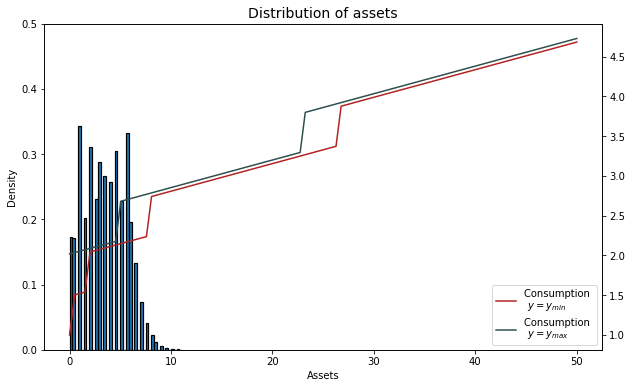

In [39]:
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/First Semester/Quantitative Macro/Problem Sets/PS4")

DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a,
          moments_fig_name="Partial Equilibrium Moments " ,dist_fig_name="Partial Equilibrium Distribution", T=100)


In [32]:
a_dist_orderd = np.sort(a_dist)
print("0-20 own", (sum(a_dist_orderd[:5000]) / sum(a_dist))*100)
print("20-40 own", (sum(a_dist_orderd[5000:10000]) / sum(a_dist))*100)
print("40-60 own", (sum(a_dist_orderd[10000:15000]) / sum(a_dist))*100)
print("60-80 own", (sum(a_dist_orderd[15000:20000]) / sum(a_dist))*100)
print("80-100 own", (sum(a_dist_orderd[20000:25000]) / sum(a_dist))*100)


print("Top 90-95 own", (sum(a_dist_orderd[22500:23750]) / sum(a_dist))*100)
print("Top 95-99 own", (sum(a_dist_orderd[23750:24750]) / sum(a_dist))*100)
print("Top 1% own", (sum(a_dist_orderd[24750:]) / sum(a_dist))*100)

0-20 own 3.869312732231779
20-40 own 11.960397815816444
40-60 own 19.96121310972635
60-80 own 27.641133860987033
80-100 own 36.567942481240394
Top 90-95 own 9.19905942281393
Top 95-99 own 8.322862983388928
Top 1% own 2.4987231106167913


In [33]:
gini(a_dist)

0.33967135729255743

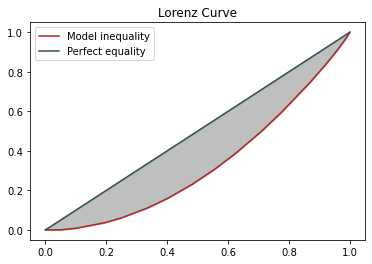

In [34]:
import quantecon as qe


f_vals, l_vals = qe.lorenz_curve(a_dist)

fig, ax = plt.subplots(facecolor="w")
ax.plot(f_vals, l_vals, label="Model inequality", c="firebrick")
ax.plot(f_vals, f_vals, label="Perfect equality", c="darkslategrey")
plt.fill_between(f_vals, l_vals, f_vals, color="grey", alpha=0.5 )
ax.legend()
plt.title("Lorenz Curve")
plt.show()
fig.savefig("Base, lorenz curve")

In [71]:
def GeneralEq(r, k_r, Ea, Aiyagari = False, p=p, CV=cv, m=3, N=4):

    r_curr = Symbol("r_curr")

    r_new = 0
    w_r = 0

    capital = [k_r]
    assets = [Ea]


    D = k_r - Ea

    niters_KE = 1

    while np.abs(D) > 0.01 and niters_KE < 500:

        Ea = assets[-1]

        sol = solve(((r_curr) / alpha)**(1/(alpha-1)) - Ea, r_curr)

        r_new = sol[0]

        k_r = ((r_new) / alpha)**(1/(alpha-1))
        w_r = k_r**alpha - r_new*k_r

        if Aiyagari == False:

            solution = SolveModel(utility=CRRA, Borrowing=False, sigma=2, sigma_y=0.5, w=w_r,
                                  r=r_new, a_max=50, a_num=100)

        if Aiyagari == True:

            solution = SolveModel(utility=CRRA, Borrowing=False, Aiyagari=True, p=p, CV=cv, m=3, N=4, sigma=2,
                                  sigma_y=0.5, w=w_r, r=r_new, a_max=50, a_num=100)

        global V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy

        V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy = solution

        solution_dist = invar_dist(ga, trans_mat, a_grid, Aiyagari=Aiyagari)

        global T, N_a, a_dist, mean_a, var_a, median_a, skew_a

        T, N_a, a_dist, Ea, mean_a, var_a, median_a, skew_a = solution_dist

        assets.append(Ea)
        capital.append(k_r)

        niters_KE = niters_KE+1

        D = k_r - Ea

        print(f"Number of iterations is {niters_KE}")
        print(f"D = {D}")

    print(f"Equilibrium interest rate is {r_new}")
    print(f"Equilibrium wage is {w_r}")
    print(f"Equilibrium capital is {k_r}", f"and assets {Ea}")

    solution = [r_new, k_r, Ea, w_r, a_dist, gc, mean_a, var_a, median_a, skew_a]

    return solution



In [135]:
solution = GeneralEq(r, k_r, Ea)

Number of iterations is 2
D = 0.185248820201998
Number of iterations is 3
D = -7.10542735760100E-15
Equilibrium interest rate is 0.0309664641287289
Equilibrium wage is 2.14890462191513
Equilibrium capital is 34.1794176080808 and assets 34.17941760808081


In [24]:
r, k_r, Ea, w_r, a_dist, gc, mean_a, var_a, median_a, skew_a = solution

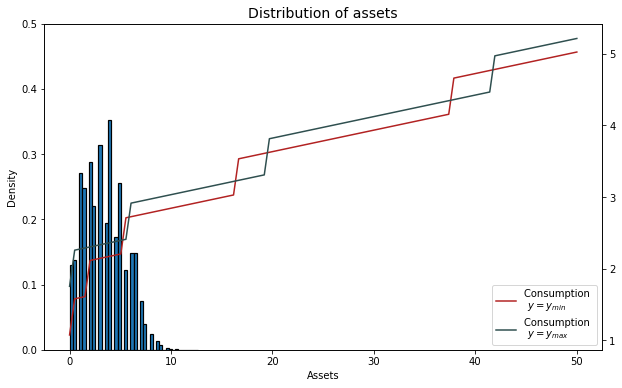

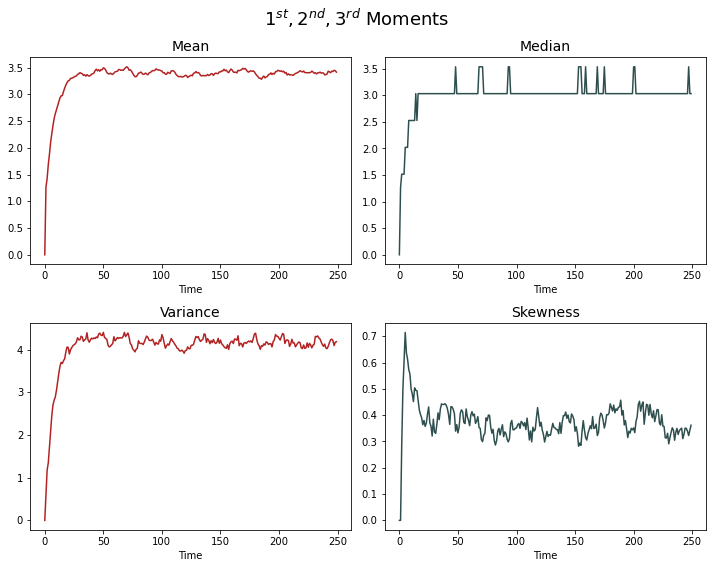

In [26]:
DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a, moments_fig_name="General Equilibrium Moments" ,
          dist_fig_name="General Eq Distribution", T=250)

In [36]:
from scipy import stats
dist_stats = np.quantile(a_dist, [0.99])
dist_stats

array([8.08164646])

In [ ]:
dist_summary = stats.describe(a_dist)
dist_summary

In [41]:
a_dist_orderd = np.sort(a_dist)
print("0-20 own", (sum(a_dist_orderd[:5000]) / sum(a_dist))*100)
print("20-40 own", (sum(a_dist_orderd[5000:10000]) / sum(a_dist))*100)
print("40-60 own", (sum(a_dist_orderd[10000:15000]) / sum(a_dist))*100)
print("60-80 own", (sum(a_dist_orderd[15000:20000]) / sum(a_dist))*100)
print("80-100 own", (sum(a_dist_orderd[20000:25000]) / sum(a_dist))*100)


print("Top 90-95 own", (sum(a_dist_orderd[22500:23750]) / sum(a_dist))*100)
print("Top 95-99 own", (sum(a_dist_orderd[23750:24750]) / sum(a_dist))*100)
print("Top 1% own", (sum(a_dist_orderd[24750:]) / sum(a_dist))*100)

0-20 own 4.5149432171857455
20-40 own 12.029505074964593
40-60 own 19.458365228372017
60-80 own 26.396657005034978
80-100 own 37.600529474443036
Top 90-95 own 9.631379208853891
Top 95-99 own 8.638128956880983
Top 1% own 2.6115348489997543


In [42]:
gini(a_dist)

0.3386787978604582

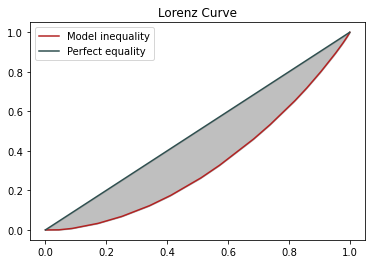

In [43]:
import quantecon as qe


f_vals, l_vals = qe.lorenz_curve(a_dist)

fig, ax = plt.subplots(facecolor="w")
ax.plot(f_vals, l_vals, label="Model inequality", c="firebrick")
ax.plot(f_vals, f_vals, label="Perfect equality", c="darkslategrey")
plt.fill_between(f_vals, l_vals, f_vals, color="grey", alpha=0.5 )
ax.legend()
plt.title("Lorenz Curve")
plt.show()
fig.savefig("Base, lorenz curve")

In [ ]:
limits = [(0.045, 0.05), (0.04, 0.049), (0.04, 0.049),
          (0.038, 0.045), (0.036, 0.042), (0.035, 0.045),
          (0.038, 0.044), (0.035, 0.045), (0.035, 0.045),
          (0.038, 0.044), (0.03, 0.038), (0.023, 0.03),


          (0.038, 0.045), (0.03, 0.041), (0.03, 0.04),
          (0.036, 0.044), (0.031, 0.04), (0.024, 0.032),
          (0.032, 0.041), (0.022, 0.031), (0.01, 0.023),
          (0.03, 0.039), (0.01, 0.019), (-0.0035, -0.0025)]

In [43]:
def Aiyagari_stats(alpha, delta, r):

    saving_rate = (alpha*delta) / (r+delta)

    stat = f"{r} / {saving_rate}"

    return stat

Aiyagari_stats(alpha, delta, r)


'0.036 / 0.20625000000000002'

In [57]:
delta = 0.08
alpha=0.36

r = 0.065

k_r = ((r + delta) / alpha)**(1/(alpha-1))
w_r = k_r**alpha - r*k_r

solution = SolveModel(utility=CRRA, Borrowing=True, Aiyagari=True, sigma=3,
                      p=0.4, CV=0.6, sigma_y=0.5, w=w_r, r=r, m=1, N=4, a_max=60)
V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy = solution

In [58]:
solution_dist = invar_dist(ga, trans_mat, a_grid, Aiyagari=True)
T, N_a, a_dist, Ea, mean_a, var_a, median_a, skew_a = solution_dist

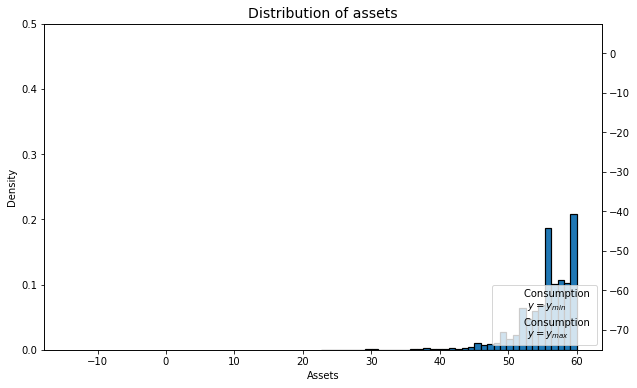

In [59]:
DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a, moments_fig_name=f"GE Aiyagari moments, model{0}",
                      dist_fig_name=f"GE Aiyagari dist, model {0} deleteme", T=500)


In [ ]:
GE_solution = GeneralEq(r, k_r, Ea, p=0.2, CV=0.3, m=3, N=7, Aiyagari=True)
r, k_r, Ea, w_r, a_dist, gc, mean_a, var_a, median_a, skew_a = GE_solution

DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a, moments_fig_name=f"GE Aiyagari moments, model{0}" ,
                      dist_fig_name=f"GE Aiyagari dist, model {0}", T=500)

r = GE_solution[0]

stat = Aiyagari_stats(alpha, delta, r)
stat

Number of iterations is 2
D = 502.096618598496
Number of iterations is 3
D = -11.7694615757584
Number of iterations is 4
D = -4.16436115555604
Number of iterations is 5
D = -0.941395313132432
Number of iterations is 6
D = -0.0236358909094747
Number of iterations is 7
D = -0.0674733979803364
Number of iterations is 8
D = -2.84217094304040E-13
Equilibrium interest rate is 0.00786978588403119
Equilibrium wage is 5.49693991806273
Equilibrium capital is 392.898707725252 and assets 392.89870772525256
sigma = 3, serial correlation = 0, coeff of var = 0.2 , r/sr = 0.00786978588403119 / 0.327757712281326
Number of iterations is 2
D = 526.929522522819
Number of iterations is 3
D = -16.3946215959607
Number of iterations is 4
D = -3.60154412929364
Number of iterations is 5
D = -0.315145212121763
Number of iterations is 6
D = -2.79044924040483
Number of iterations is 7
D = 0.0432314585848985
Number of iterations is 8
D = -1.02318153949454E-12
Equilibrium interest rate is 0.00808601039534317
Equilib

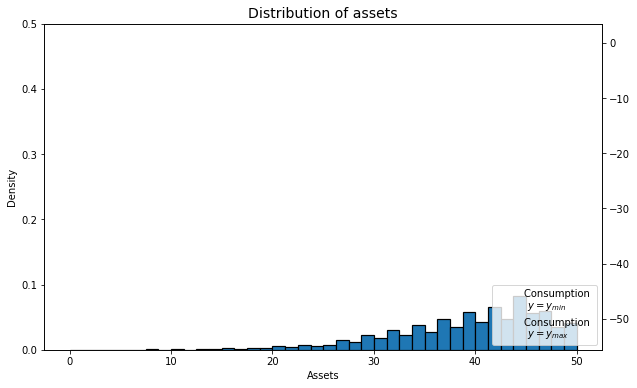

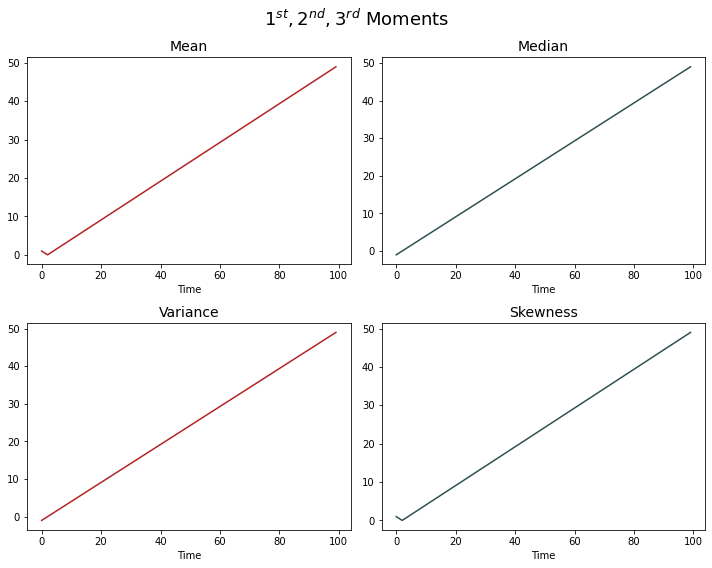

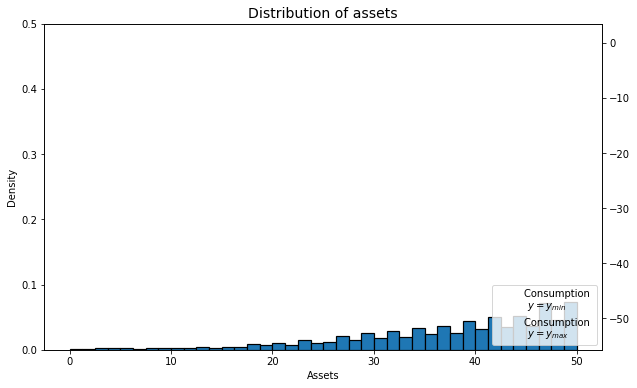

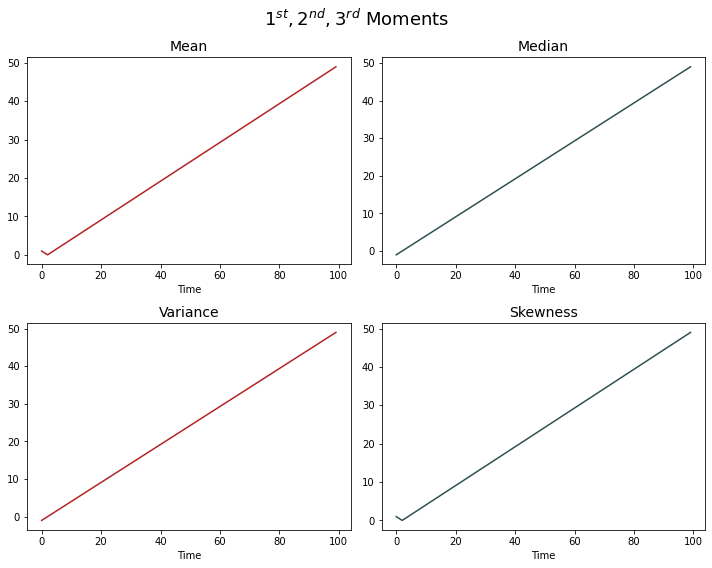

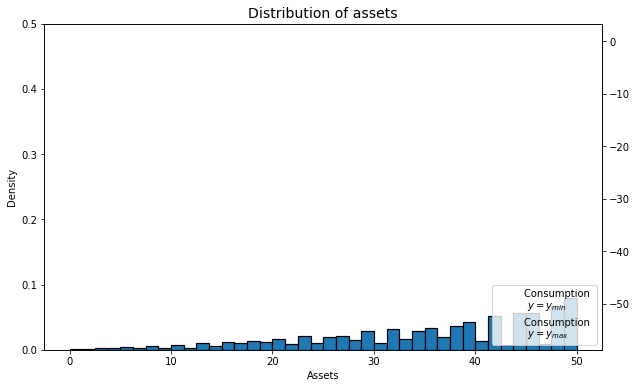

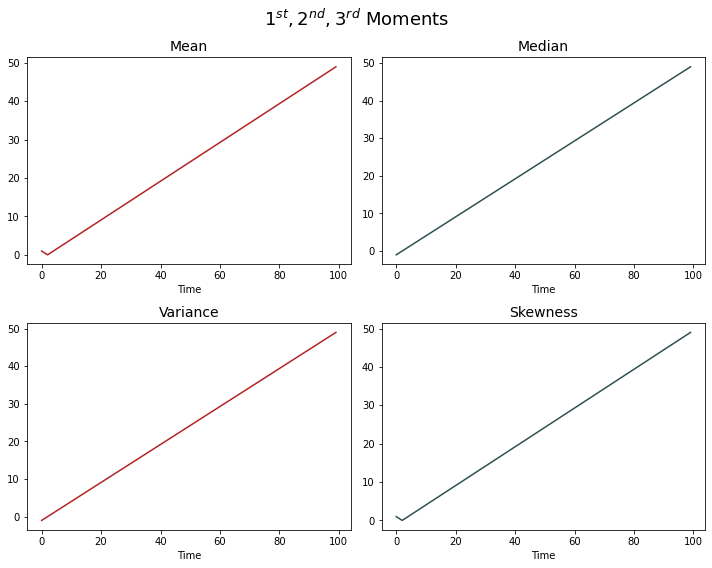

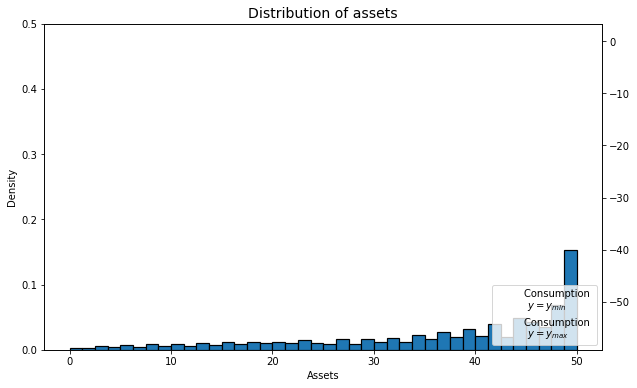

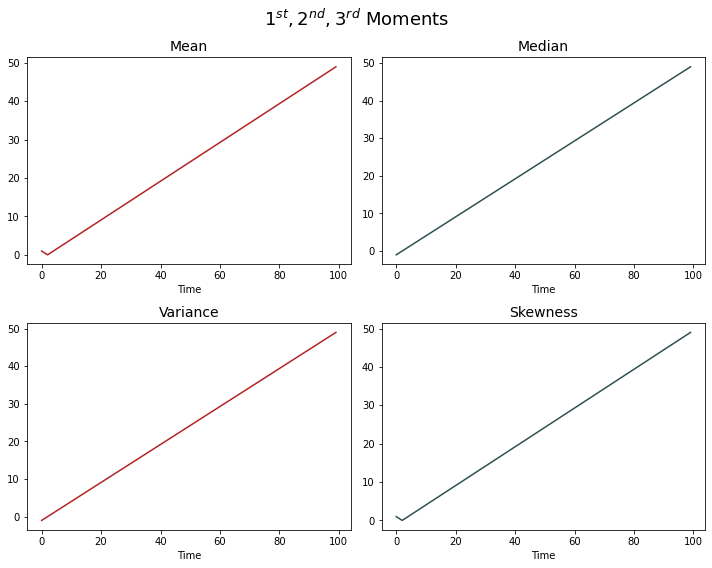

In [74]:
os.chdir("C:/Users/Joe's PC/Documents/IDEA Masters/Second Year/First Semester/Quantitative Macro/Problem Sets/PS4/Aiyagari")

Aiyagari_table2 = []

sigma_values = [3]
cv_values = [0.2, 0.4]
p_values = [0, 0.3]

model = 0

for sigma in sigma_values:
    for cv in cv_values:
        for p in p_values:


            delta = 0.08
            alpha=0.36

            r = 0.035

            k_r = ((r + delta) / alpha)**(1/(alpha-1))
            w_r = k_r**alpha - r*k_r

            solution = SolveModel(utility=CRRA, Borrowing=True, Aiyagari=True, sigma=sigma, p=p, CV=cv, sigma_y=0.5, w=w_r, r=r, m=3, N=4)
            V1, ga, gc, trans_mat, y_grid, a_grid, niters, OptimalPath, a_policy = solution

            solution_dist = invar_dist(ga, trans_mat, a_grid, Aiyagari=True)
            T, N_a, a_dist, Ea, mean_a, var_a, median_a, skew_a = solution_dist

            GE_solution = GeneralEq(r, k_r, Ea, p=p, CV=cv, m=3, N=4, Aiyagari=True)
            r, k_r, Ea, w_r, a_dist, gc, mean_a, var_a, median_a, skew_a = GE_solution

            DistPlots(a_dist, gc, mean_a, var_a, median_a, skew_a, moments_fig_name=f"GE Aiyagari moments, model{model}" ,
                      dist_fig_name=f"GE Aiyagari dist, model {model}", T=100)

            r = GE_solution[0]

            stat = Aiyagari_stats(alpha, delta, r)

            print(f"sigma = {sigma}, serial correlation = {p}, coeff of var = {cv} , r/sr = {stat}")

            Aiyagari_table2.append((sigma, p, cv ,stat))

            model = model + 1


In [77]:
Aiyagari_table2

[(3, 0, 0.2, '0.00786978588403119 / 0.327757712281326'),
 (3, 0.3, 0.2, '0.00808601039534317 / 0.326953166237650'),
 (3, 0, 0.4, '0.00837963565994691 / 0.325866923810504'),
 (3, 0.3, 0.4, '0.00819134881651612 / 0.326562643461991')]